In [1]:
import os
# directories
os.listdir('../input/histopathologic-cancer-detection/')

['sample_submission.csv', 'train_labels.csv', 'test', 'train']

# Histopathologic Cancer Detection with CNN

**Overview**

In this project, we will be creating an algorithm to categorize and identify metastatic cancer in small image patches from digital pathology scans. First, we will examine and explore the data, then we will run convolutional neural network models to classify cancerous and non-cancerous cells. 

We will be using Convolutional Neural Networks (CNNs), a category of deep neural networks renowned for their prowess in analyzing visual data. CNNs prove especially fitting for this purpose given their capacity to discern patterns and characteristics within images. This attribute makes them particularly adept at discerning nuanced differences in tissue samples that signify the presence of cancerous cells.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle
import shutil

from skimage.transform import rotate
from skimage import io
import cv2 as cv

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip, RandomZoom, RandomRotation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

In [3]:
# let's look at the number of images in training and test set 
print(len(os.listdir('../input/histopathologic-cancer-detection/train')))
print(len(os.listdir('../input/histopathologic-cancer-detection/test')))

220025
57458


We can see that there are 220,025 images in the training dataset and 57,458 images in the test data set. This is a good proportion!

In [4]:
train_data = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')
sample_submission = pd.read_csv('../input/histopathologic-cancer-detection/sample_submission.csv')
test_path = '../input/histopathologic-cancer-detection/test/'
train_path = '../input/histopathologic-cancer-detection/train/'
test_data = pd.DataFrame({'id':os.listdir(test_path)})

print(train_data.shape)

# declare constants for reproduciblity
random_state = 101

(220025, 2)


## Exploratory Data Analysis

In [5]:
train_data.sample(10)

,id,label
129850,7703895cf0a1f1e50b6a4cc6b4e2fdedf2b667e3,0
12151,7b36d7c1944ef250ea4be06705660760e8e1262b,0
47593,78c2d761bbf372692849dbf87a863b1d9e290fe8,0
202639,65195ce54f8ed161daa50bf92b3bcf7ae85b00f4,1
131640,2e2e661170be348a0ba572b924328347ec966493,0
27920,ef13586519a42bb6e30911164bcdb8b108eed8e9,1
84326,e90fc12255a758db707a948e0dc1b242863a76b4,1
88970,c6e3bc84d4c240ab6b53feee041edf2309f965f1,1
52258,c7bcb194b7f9b45774c5b76ee1ba6a8166055d1b,0
217367,94ab589aa692235c112a2775ef210d1bc5c387a8,0


In [6]:
tdlabel = train_data.label
cc = (tdlabel == 1).sum()
print("Cancerous Cells:", cc)

dd = (tdlabel == 0).sum()
print("Non-Cancerous Cells:", dd)

print(cc/(cc+dd))

Cancerous Cells: 89117
Non-Cancerous Cells: 130908
0.40503124644926713


In [7]:
test_data.sample(10)

,id
40707,c4527b297dc8305ddbd97a634e1a63fad73cb594.tif
32686,a029de26d65ee9609b14667e478e96f756319663.tif
38083,30ceacbd37b4912ce4cf359bb2166fe2ea92bd42.tif
26538,28d25ad65bad4865069e22afe4111286a11ead5d.tif
43383,5faf8e66dbce75bbf85d4bbc6108952bb8c8556a.tif
56512,dce81d977d996e94e6d292ee47c10c5cc1a4bbda.tif
23440,3dff2e7609330e0a48d6e4e0f310558b1f99cff0.tif
12655,b88402dc62dce942a1359497a571170f5aea6a77.tif
50383,9cddf0876a30db73afb8279273e0e122ec8faa8b.tif
30808,b7a028c6c730ac5dc9aa1a60c8eae1d0562275c4.tif


We can see from the EDA that there is a 40/60 split between cancerous(1) and non-cancerous(0) cells, which is a fairly balanced dataset for predictions.

Now, we will visualize the data.

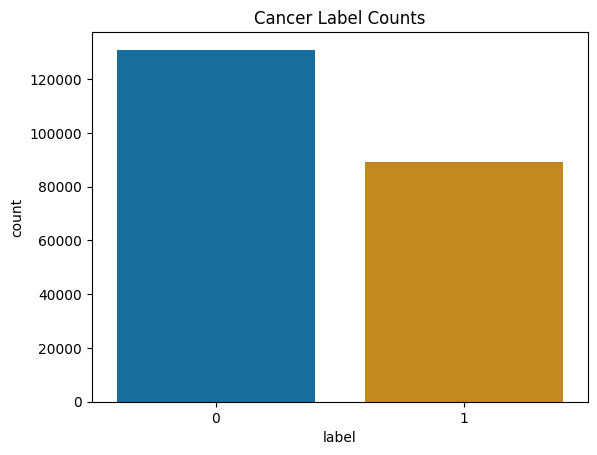

In [8]:
sns.countplot(x=train_data['label'], palette='colorblind').set(title='Cancer Label Counts');

# Model Architecture

We will be using the Keras library to run a convolutional neural network (CNN). We will be running two models: one with hyperparameters and one without.

Our CNN model will have a network with two convolutional layers then a MaxPool layer, repeated n number of times. Our model will have two (n=2) of these clusters.

First model:

Normalized images pre-training (image/255)
Output layer activation (sigmoid)

Second model:

Normalized images pre-training (image/255)
Output layer activation (sigmoid)
Dropout (0.1)
Batch Normalization
Optimization (Adam)
Learning rate (0.0001)
Hidden layer activations (ReLU)


Normalize images : this will divide each pixel by 255 to normalize the data
Output layer activation : will be a sigmoid activation function on the output layer
Dropout : set dropout at 0.1 randomly select weights and set them to equal 0 to regularize the model
Optimization : use adaptive moment estimation (Adam) for optimizing the model
Learning rate: set learning rate to 0.0001 to assist in the gradient descent such that as the model learns, the speed of learning decreases so that it is less likely to overstep the global minimum
Hidden layer activations: use rectified linear regression (ReLU) as our hidden layer activation function

In [9]:
# set model constants
batchsize = 256

In [10]:
# prepare data for training
def append_tif(string):
    return string+".tif"

train_data["id"] = train_data["id"].apply(append_tif)
train_data['label'] = train_data['label'].astype(str)

train_data = shuffle(train_data, random_state=random_state)

In [11]:
# split data into training and validation sets
datagen = ImageDataGenerator(rescale=1./255.,
                            validation_split=0.15)

In [12]:
# generate training data
train_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="training",
    batch_size=batchsize,
    seed=random_state,
    class_mode="binary",
    target_size=(64,64)) 

# generate validation data
valid_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="validation",
    batch_size=batchsize,
    seed=random_state,
    class_mode="binary",
    target_size=(64,64))  

Found 187022 validated image filenames belonging to 2 classes.
Found 33003 validated image filenames belonging to 2 classes.


In [13]:
tpu = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy()

### Model 1

In [14]:
# set ROC AUC as metric
ROC_1 = tf.keras.metrics.AUC()

# use GPU
with strategy.scope():
    
    #model design
    model_one = Sequential()
    
    model_one.add(Conv2D(filters=16, kernel_size=(3,3)))
    model_one.add(Conv2D(filters=16, kernel_size=(3,3)))
    model_one.add(MaxPooling2D(pool_size=(2,2)))

    model_one.add(Conv2D(filters=32, kernel_size=(3,3)))
    model_one.add(Conv2D(filters=32, kernel_size=(3,3)))
    model_one.add(AveragePooling2D(pool_size=(2,2)))

    model_one.add(Flatten())
    model_one.add(Dense(1, activation='sigmoid'))
    
    #model input size
    model_one.build(input_shape=(batchsize, 64, 64, 3))        # original image = (96, 96, 3) 
    
    #compiling
    model_one.compile(loss='binary_crossentropy', metrics=['accuracy', ROC_1])
    
model_one.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (256, 62, 62, 16)         448       
                                                                 
 conv2d_1 (Conv2D)           (256, 60, 60, 16)         2320      
                                                                 
 max_pooling2d (MaxPooling2  (256, 30, 30, 16)         0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (256, 28, 28, 32)         4640      
                                                                 
 conv2d_3 (Conv2D)           (256, 26, 26, 32)         9248      
                                                                 
 average_pooling2d (Average  (256, 13, 13, 32)         0         
 Pooling2D)                                             

In [15]:
# training the model
history_model_one = model_one.fit_generator(
                        train_generator,
                        epochs = 10,
                        validation_data = valid_generator)

/tmp/ipykernel_19/2693451645.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_model_one = model_one.fit_generator(


Epoch 1/10
731/731 [==============================] - 1550s 2s/step - loss: 0.5936 - accuracy: 0.6955 - auc: 0.7410 - val_loss: 0.5325 - val_accuracy: 0.7502 - val_auc: 0.8074
Epoch 2/10
731/731 [==============================] - 1017s 1s/step - loss: 0.5418 - accuracy: 0.7395 - auc: 0.7943 - val_loss: 0.5246 - val_accuracy: 0.7595 - val_auc: 0.8193
Epoch 3/10
731/731 [==============================] - 1089s 1s/step - loss: 0.5119 - accuracy: 0.7605 - auc: 0.8210 - val_loss: 0.4790 - val_accuracy: 0.7810 - val_auc: 0.8473
Epoch 4/10
731/731 [==============================] - 959s 1s/step - loss: 0.4919 - accuracy: 0.7732 - auc: 0.8369 - val_loss: 0.4793 - val_accuracy: 0.7827 - val_auc: 0.8496
Epoch 5/10
731/731 [==============================] - 864s 1s/step - loss: 0.4790 - accuracy: 0.7805 - auc: 0.8461 - val_loss: 0.4840 - val_accuracy: 0.7854 - val_auc: 0.8594
Epoch 6/10
731/731 [==============================] - 817s 1s/step - loss: 0.4708 - accuracy: 0.7837 - auc: 0.8515 - val_l

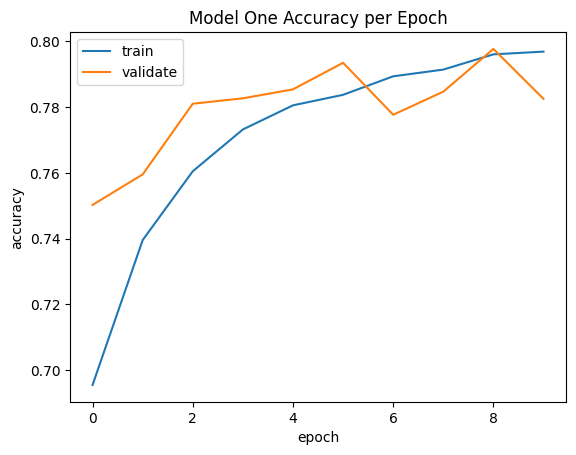

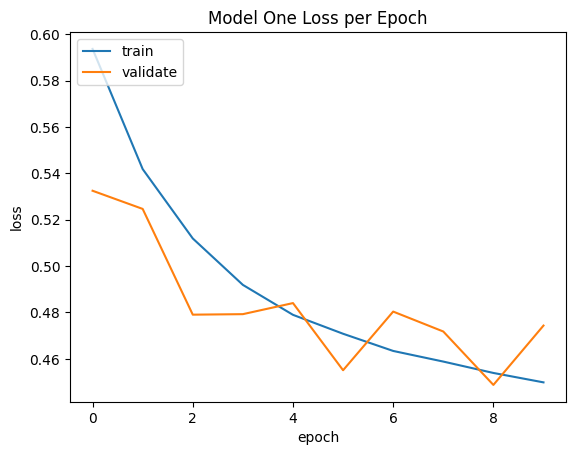

In [16]:
# plot model accuracy per epoch 
plt.plot(history_model_one.history['accuracy'])
plt.plot(history_model_one.history['val_accuracy'])
plt.title('Model One Accuracy per Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

# plot model loss per epoch
plt.plot(history_model_one.history['loss'])
plt.plot(history_model_one.history['val_loss'])
plt.title('Model One Loss per Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

### Model 2

In [17]:
ROC_2 = tf.keras.metrics.AUC()

with strategy.scope():
    
    #create model
    model_two = Sequential()
    
    model_two.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', ))
    model_two.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
    model_two.add(MaxPooling2D(pool_size=(2,2)))
    model_two.add(Dropout(0.1))
    
    model_two.add(BatchNormalization())
    model_two.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
    model_two.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
    model_two.add(AveragePooling2D(pool_size=(2,2)))
    model_two.add(Dropout(0.1))
    
    model_two.add(BatchNormalization())
    model_two.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
    model_two.add(Flatten())
    model_two.add(Dense(1, activation='sigmoid'))
    
    #build model by input size
    model_two.build(input_shape=(batchsize, 64, 64, 3))       # original image = (96, 96, 3) 
    
    #compile
    adam_optimizer = Adam(learning_rate=0.0001)
    model_two.compile(loss='binary_crossentropy', metrics=['accuracy', ROC_2], optimizer=adam_optimizer)

#quick look at model
model_two.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (256, 62, 62, 16)         448       
                                                                 
 conv2d_5 (Conv2D)           (256, 60, 60, 16)         2320      
                                                                 
 max_pooling2d_1 (MaxPoolin  (256, 30, 30, 16)         0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (256, 30, 30, 16)         0         
                                                                 
 batch_normalization (Batch  (256, 30, 30, 16)         64        
 Normalization)                                                  
                                                                 
 conv2d_6 (Conv2D)           (256, 28, 28, 32)        

In [18]:
# training model 2
history_model_two = model_two.fit_generator(
                        train_generator,
                        epochs = 10,
                        validation_data = valid_generator)

/tmp/ipykernel_19/1691481122.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_model_two = model_two.fit_generator(


Epoch 1/10
731/731 [==============================] - 969s 1s/step - loss: 0.4732 - accuracy: 0.7793 - auc_1: 0.8485 - val_loss: 0.6668 - val_accuracy: 0.7145 - val_auc_1: 0.8781
Epoch 2/10
731/731 [==============================] - 972s 1s/step - loss: 0.4118 - accuracy: 0.8182 - auc_1: 0.8873 - val_loss: 0.5803 - val_accuracy: 0.7709 - val_auc_1: 0.8849
Epoch 3/10
731/731 [==============================] - 926s 1s/step - loss: 0.3881 - accuracy: 0.8321 - auc_1: 0.9006 - val_loss: 0.5825 - val_accuracy: 0.7860 - val_auc_1: 0.8798
Epoch 4/10
731/731 [==============================] - 970s 1s/step - loss: 0.3659 - accuracy: 0.8426 - auc_1: 0.9131 - val_loss: 0.5800 - val_accuracy: 0.7747 - val_auc_1: 0.9094
Epoch 5/10
731/731 [==============================] - 937s 1s/step - loss: 0.3416 - accuracy: 0.8553 - auc_1: 0.9250 - val_loss: 0.3516 - val_accuracy: 0.8549 - val_auc_1: 0.9315
Epoch 6/10
731/731 [==============================] - 972s 1s/step - loss: 0.3194 - accuracy: 0.8655 - au

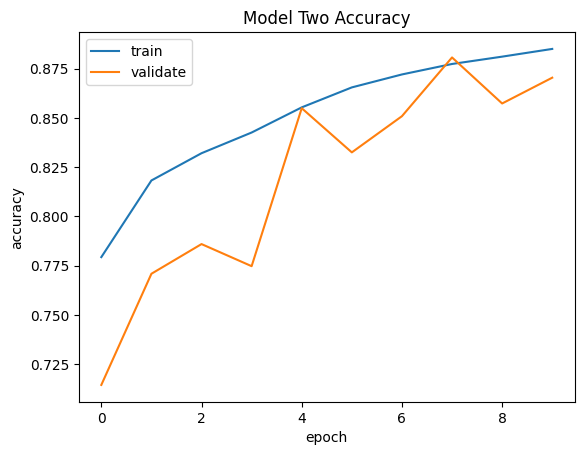

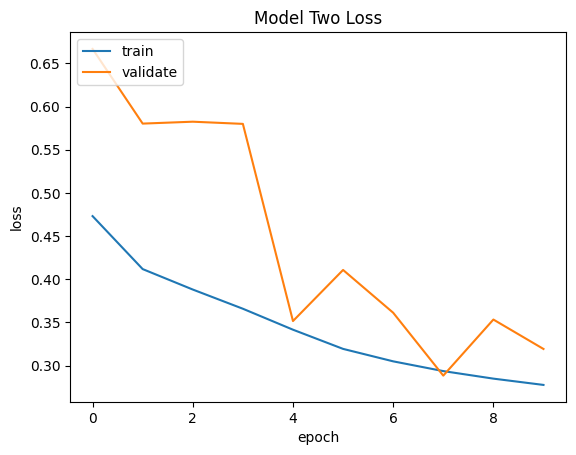

In [19]:
plt.plot(history_model_two.history['accuracy'])
plt.plot(history_model_two.history['val_accuracy'])
plt.title('Model Two Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

plt.plot(history_model_two.history['loss'])
plt.plot(history_model_two.history['val_loss'])
plt.title('Model Two Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();


In [20]:
# preparing test data
datagen_test = ImageDataGenerator(rescale=1./255.)

test_generator = datagen_test.flow_from_dataframe(
    dataframe=test_data,
    directory=test_path,
    x_col='id', 
    y_col=None,
    target_size=(64,64),         
    batch_size=1,
    shuffle=False,
    class_mode=None)

Found 57458 validated image filenames.


In [21]:
#creating predictions

predictions = model_two.predict(test_generator, verbose=1)

57458/57458 [==============================] - 445s 8ms/step


In [22]:
#create submission dataframe
predictions = np.transpose(predictions)[0]
submission_df = pd.DataFrame()
submission_df['id'] = test_data['id'].apply(lambda x: x.split('.')[0])
submission_df['label'] = list(map(lambda x: 0 if x < 0.5 else 1, predictions))
submission_df.head()

,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,1
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,0
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,1
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,0


In [23]:
submission_df['label'].value_counts()

label
0    34225
1    23233
Name: count, dtype: int64

In [24]:
#Competition Submission
submission_df.to_csv('submission.csv', index=False)

# Conclusion and Results 

**Results**

From the plots and model summaries, we can see that model 2 outperformed model 1. This was most likely due to the hyperparameter tuning.

**Conclusion**

The model performed well but took quite long to train. To improve in future models, I think that we could process the images more to allow for more variations within the data. In addition, we could also train with more epochs, but we want to be careful to not overfit the data. We only trained with 10 epochs due to time and processing constraints. 